In [1]:
import numpy as np, matplotlib.pyplot as plt, tqdm

In [2]:
from numpy import genfromtxt
data = genfromtxt('./speed_record.csv', delimiter=',', dtype=str)

T, V, W, LR, D = data.T
T = T.astype('float')
T -= T.min()
V = V.astype('float')
W = W.astype('float')

LR[LR=='l'] = '0'
LR[LR=='r'] = '1'
R = LR.astype(bool)
del LR

D[D == 'MAX'] = 'inf'
D[D == 'MIN'] = '-inf'
D = D.astype('float')

In [3]:
DT = np.diff(T)

In [4]:
dt_thresh = 2

In [5]:
max(DT[DT<dt_thresh])

0.18000006675720215

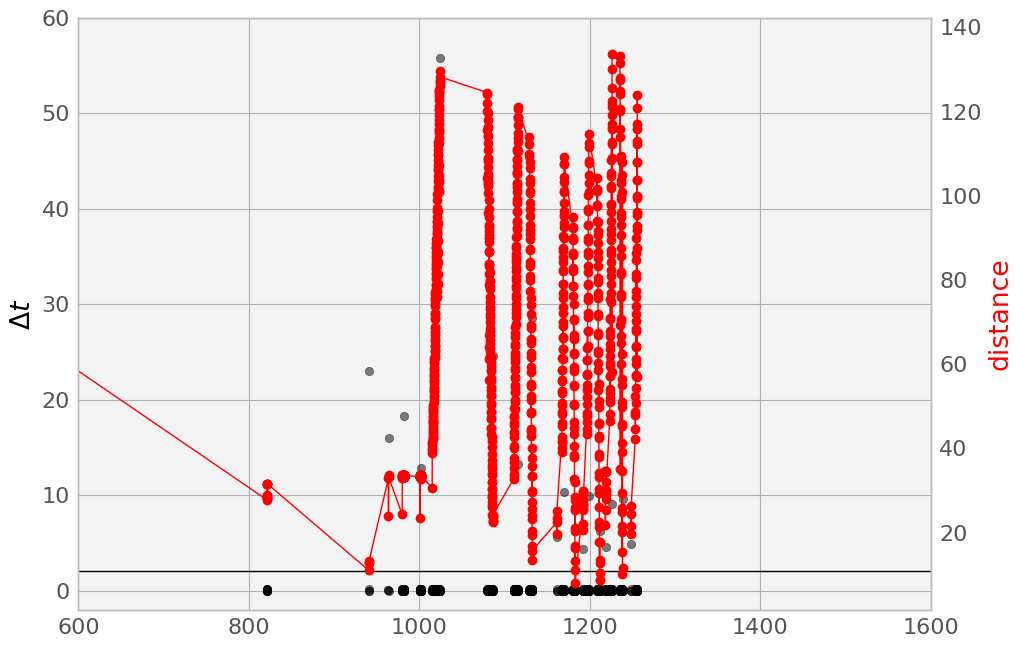

In [6]:
t0 = 600
dt = 1000

fig, ax = plt.subplots()
ax.scatter(T[:-1], DT, marker='o', color='black', alpha=.5)
ax.set_xlim(t0, t0+42)
ax.set_ylim(-2, 60)
ax.set_ylabel('$\Delta t$', color='black')
ax.axhline(dt_thresh, color='black')

ax = ax.twinx()
ax.plot(T, D, marker='o', color='red')
ax.set_xlim(t0, t0+dt)
ax.set_ylabel('distance', color='red')
ax.set_xlabel('$t$')
ax.grid(False)

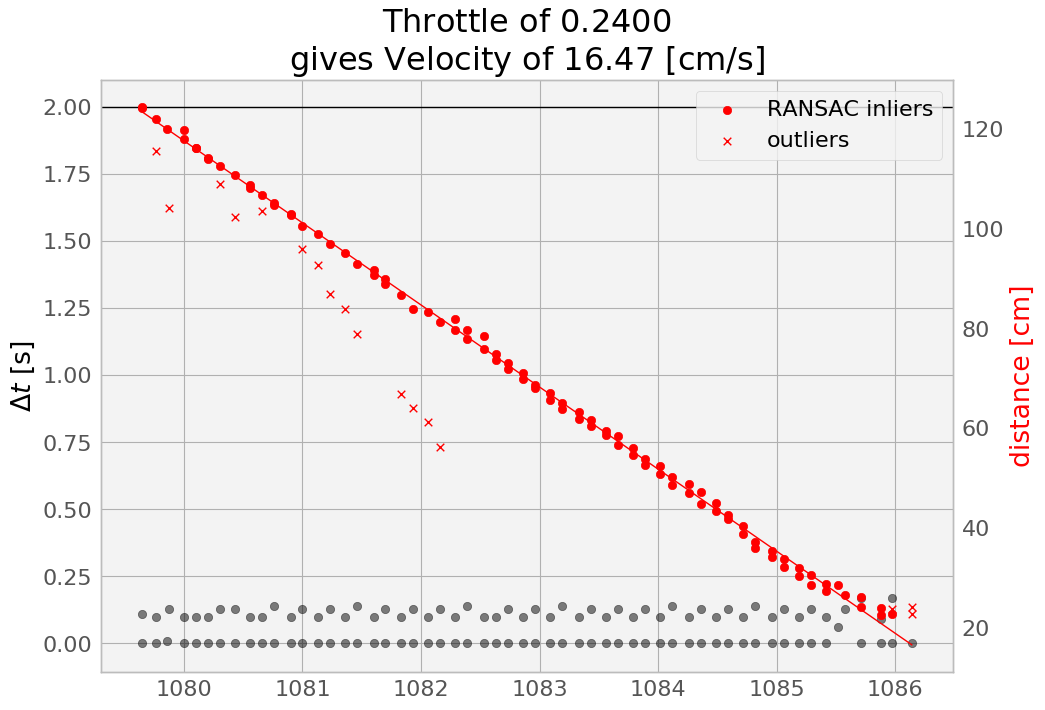

In [7]:
from sklearn import linear_model

class Experiment(object):
    
    def __init__(self):
        self.T = []
        self.V = []
        self.W = []
        self.R = []
        self.D = []
        
    def append(self, t, v, w, r, d):
        self.T.append(t)
        self.V.append(v)
        self.W.append(w)
        self.R.append(r)
        self.D.append(d)
        self._fitted = False
        
    def fit(self):
        def is_data_valid(X, y):
            return (np.isfinite(X).all() and np.isfinite(y).all())
        
        self._ransac = ransac = linear_model.RANSACRegressor(is_data_valid=is_data_valid, residual_threshold=3.5)
        
        T = np.array(self.T).reshape(-1, 1)
        D = np.array(self.D)
        
        D[D == np.inf ] = 1e9
        D[D == -np.inf] = -1e9
        
        ransac.fit(T, D)
        
        self._cmps = -ransac.estimator_.coef_[0]
        self._fitted = True
        
    @property
    def ransac(self):
        if not self._fitted: self.fit()
        return self._ransac
        
    @property
    def cmps(self):
        if not self._fitted: self.fit()
        return self._cmps
    
    def __len__(self):
        return len(self.T)
    
    @property
    def mean_throttle(self):
        return np.mean(self.V)
    
    @property
    def mean_steer(self):
        return np.mean(self.W)
        
        
    def show(self):
        DT = np.diff(self.T)

        fig, ax = plt.subplots()
        ax.scatter(self.T[:-1], DT, color='black', alpha=.5)
        ax.set_ylabel('$\Delta t$ [s]', color='black')
        ax.axhline(dt_thresh, color='black')

        bx = ax.twinx()
#         bx.scatter(self.T, self.D, color='red')
        bx.set_ylabel('distance [cm]', color='red')
        bx.set_xlabel('$t$')
        bx.grid(False)
        
        ransac = self.ransac
        smooth = np.linspace(min(self.T), max(self.T), 1000)
        
        inliers = ransac.inlier_mask_
        outliers = np.logical_not(inliers)
        T = np.array(self.T)
        D = np.array(self.D)
        bx.scatter(T[inliers], D[inliers], color='red', label='RANSAC inliers')
        bx.scatter(T[outliers], D[outliers], s=30, color='red', marker='x', label='outliers')
        bx.plot(smooth, ransac.predict(smooth.reshape((-1, 1))), color='red')
        bx.legend()
        
        ax.set_title(
            r'Throttle of $%.4f$' % self.mean_throttle
            +'\n'
            +r'gives Velocity of $%.2f$ [cm/s]' % self.cmps
        )
        
        return fig, (ax, bx)

    
experiments = [Experiment()]

for t, v, w, r, d, dt in zip(T, V, W, R, D, DT):
    
    experiments[-1].append(t, v, w, r, d)
    
    if dt > dt_thresh:
        experiments.append(Experiment())
    
fig, axes = experiments[15].show()
fig.savefig('sample_experiment.png');

Negative throttle rate is 553.8152877934955 (cm/s)/throttle.
Positive throttle rate is 629.4356808311268 (cm/s)/throttle.


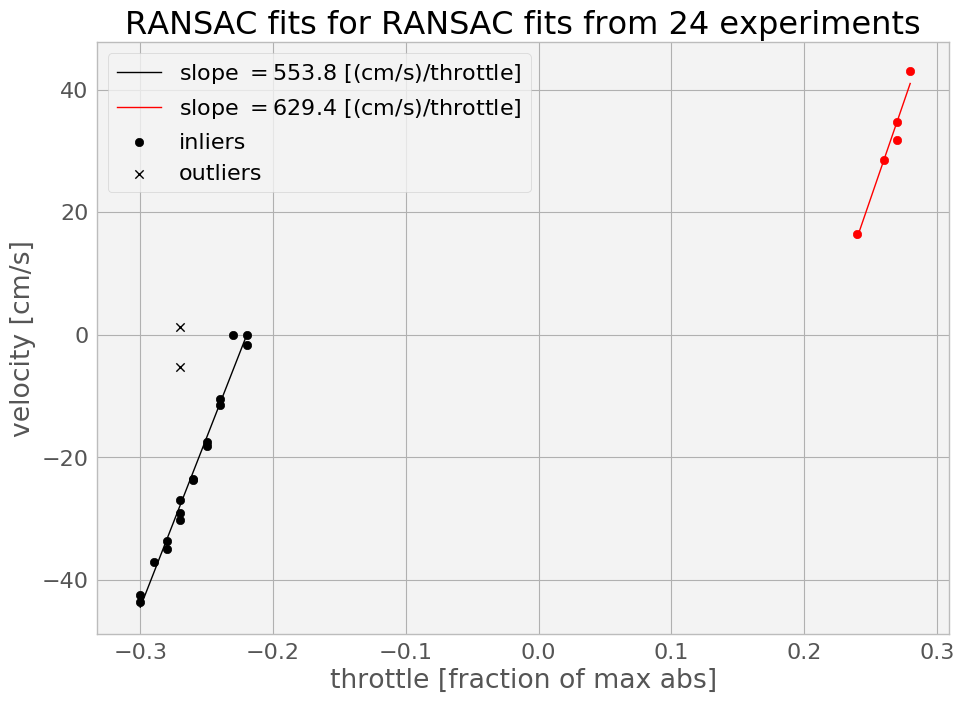

In [8]:
throttles = []
velocities = []
for e in experiments:
    if len(e) > 10:
        throttles.append(e.mean_throttle)
        velocities.append(e.cmps)
        
throttles = np.array(throttles)
velocities = np.array(velocities)
        
order = np.argsort(throttles)
throttles = throttles[order]
velocities = velocities[order]

fig, ax = plt.subplots()

thr1 = throttles[throttles<0]
vel1 = velocities[throttles<0]
ransac1 = linear_model.RANSACRegressor(residual_threshold=8)
ransac1.fit(thr1.reshape((-1, 1)), vel1)
in1 = ransac1.inlier_mask_
out1 = np.logical_not(in1)

thr2 = throttles[throttles>0]
vel2 = velocities[throttles>0]
ransac2 = linear_model.RANSACRegressor(residual_threshold=8)
ransac2.fit(thr2.reshape((-1, 1)), vel2)
in2 = ransac2.inlier_mask_
out2 = np.logical_not(in2)

ax.scatter(thr1[in1], vel1[in1], color='black', label='inliers')
ax.scatter(thr1[out1], vel1[out1], marker='x', color='black', label='outliers')
x = np.linspace(thr1.min(), thr1.max(), 100)
ax.plot(x, ransac1.predict(x.reshape((-1, 1))), color='black',
       label='slope $=%.1f$ [(cm/s)/throttle]' % ransac1.estimator_.coef_[0])
print('Negative throttle rate is', ransac1.estimator_.coef_[0], '(cm/s)/throttle.')

ax.scatter(thr2[in2], vel2[in2], color='red')
ax.scatter(thr2[out2], vel2[out2], marker='x', color='red')
x = np.linspace(thr2.min(), thr2.max(), 100)
ax.plot(x, ransac2.predict(x.reshape((-1, 1))), color='red',
        label='slope $=%.1f$ [(cm/s)/throttle]' % ransac2.estimator_.coef_[0])
print('Positive throttle rate is', ransac2.estimator_.coef_[0], '(cm/s)/throttle.')

ax.legend()

ax.set_title('RANSAC fits for RANSAC fits from %d experiments' % len(throttles))

ax.set_xlabel('throttle [fraction of max abs]')
ax.set_ylabel('velocity [cm/s]')
fig.savefig('throttle_rates.png')